In [1]:
!pip install gcm-filters

In [2]:
!pip install gsw

# Dask start

In [1]:
from dask.distributed import Client, progress

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38045")
client

<Client: 'tcp://127.0.0.1:38045' processes=4 threads=8, memory=29.40 GiB>

# Import

In [3]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gcm_filters
import gsw
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from importlib import reload
import scipy.signal

# Load data

Load Pangeo catalog

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

Winter data:

In [7]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

In [8]:
enatl01w

<xarray.Dataset>
Dimensions:        (time_counter: 2136, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

Summer data:

In [9]:
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

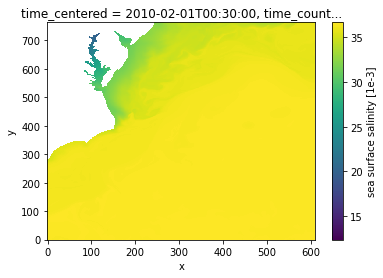

In [10]:
enatl01w.sosaline.isel(time_counter=0).plot()

# Prepare data for filter

## Slicing

In [11]:
enatl01s.time_counter.size

2208

In [12]:
# x_slice = slice(300,600)
# y_slice = slice(400,700)

In [13]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

In [14]:
data_slice = dict(time_counter=slice(0,-1),y=y_slice,x=x_slice)

In [15]:
coord_slice = dict(y=y_slice,x=x_slice)

## Grid

In [16]:
area = xr.DataArray((enatl01w.e1t[coord_slice] * enatl01w.e2t[coord_slice]), dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load()
# area.plot()

Spacings:

In [17]:
dxw = xr.DataArray(enatl01w.e1u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at southern cell edge

In [18]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1289.53776172)

Diffusivities for thefilter in the east-west and north-south directions

In [19]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

## Mask

In [20]:
wet_mask = xr.DataArray(enatl01w.umask[coord_slice],
                        dims=['y','x'],
                        coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
           ).load()

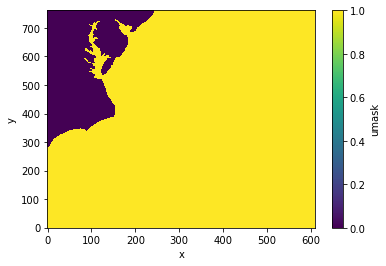

In [21]:
wet_mask.plot()

## High-resolution dataset

In [22]:
dataHR = xr.Dataset({"sst" : enatl01s.sosstsst[data_slice],
                     "sal" : enatl01s.sosaline[data_slice],
                     "wet_mask" : wet_mask},
                    coords=enatl01s[data_slice].coords)

# Filter

## Define filter

Parameters (to determine) :

In [23]:
filter_scale = 30000

In [24]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,    
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)

In [25]:
# gaussian_filter = gcm_filters.Filter(
#     filter_scale=6,   # 12 grid cells
#     dx_min=1,
#     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#     grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
#     grid_vars={
#         'wet_mask': wet_mask
#     }
# )

## Apply filter to data

In [26]:
# intermediate dataset: HR data + filtering (result has still the spatial resoltion if HR data)
data_filtered = xr.Dataset({}, coords=enatl01s[data_slice].coords)

"Lazy" filter execution with Dask

In [27]:
data_filtered["sst"] = gaussian_filter.apply(dataHR.sst, dims=['y', 'x'])
data_filtered["sal"] = gaussian_filter.apply(dataHR.sal, dims=['y', 'x'])

# Spatial coarsening (downsampling)

In [28]:
coarsen_window_size=12

In [29]:
# def downsample(data, window_size) :
#     return data.coarsen(x=window_size, boundary='pad').mean().coarsen(y=window_size,boundary='pad').mean()*
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=False)
    area_window_sums = area_masked.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim').sum(skipna=False)
    return data_weighted_sums/area_window_sums

In [30]:
dataLR = downsample(data_filtered, coarsen_window_size, area, wet_mask)

In [31]:
time_counter_to_plot = [1]

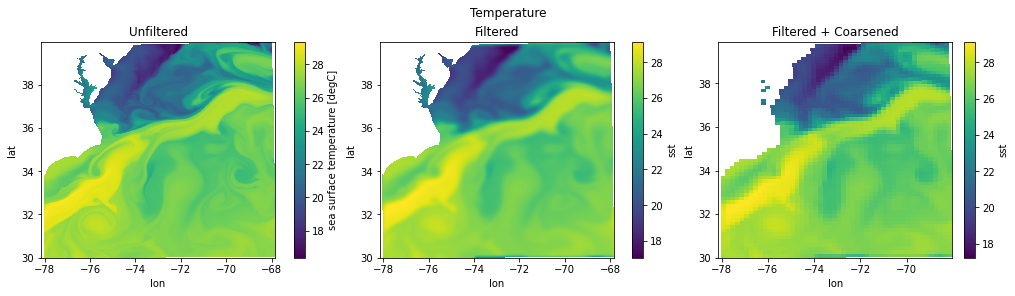

In [32]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Temperature')
(dataHR.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered')
(data_filtered.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[1],x='lon', y='lat')
#ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
ax[1].set(title=r'Filtered')
(dataLR.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[2], x='lon', y='lat')
ax[2].set(title=r'Filtered + Coarsened')
plt.show()

In [33]:
# fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
# fig.suptitle('Salinity')
# (dataHR.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[0],x='lon', y='lat')
# ax[0].set(title=r'Unfiltered')
# (data_filtered.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[1],x='lon', y='lat')
# #ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
# ax[1].set(title=r'Filtered')
# (dataLR.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[2], x='lon', y='lat')
# ax[2].set(title=r'Filtered + Coarsened')
# plt.show()

# Density computation

Convert the HR sea surface temperature to conservative temperature (CT) with the use of ```gsw``` :

In [34]:
dataHR['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataHR['sal'], dataHR['sst'], dask='parallelized')

Compute HR density with the use of ```gsw``` library function ```gsw.density.sigma0```. Calculates potential density anomaly with reference pressure of 0 dbar, this being this particular potential density minus 1000 kg/m^3. This function has inputs of Absolute Salinity and Conservative Temperature. This function uses the computationally-efficient expression for specific volume in terms of SA, CT and p (Roquet et al., 2015).

In [35]:
dataHR['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, dataHR['sal'], dataHR['CT'], dask='parallelized')

Apply filter to the density field evaluated with unfiltered salinity and SST:

In [36]:
data_filtered["sigma0_filtered"] = gaussian_filter.apply(dataHR.sigma0, dims=['y', 'x'])

Coarsen the obtained filtered desity field (is actually the density that we would like to reconstrunct):

In [37]:
dataLR["sigma0_filtered"] = downsample(data_filtered["sigma0_filtered"], coarsen_window_size, area, wet_mask)

Recalculate the density with the EOS using the filtered and coarsened temperature and salinity (density field that would result fron a LR solver and needs co be corrected):

In [38]:
dataLR["CT"] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataLR['sal'], dataLR['sst'], dask='parallelized')

In [39]:
dataLR["sigma0"] = xr.apply_ufunc(gsw.density.sigma0, dataLR["sal"], dataLR["CT"], dask='parallelized')

In [40]:
dataLR["delta_sigma0"] = dataLR["sigma0_filtered"] - dataLR["sigma0"]

In [41]:
# a slice to cut the borders of the 2D maps 
slice_cut = dict(x=slice(5,-5),y=slice(5,-5))

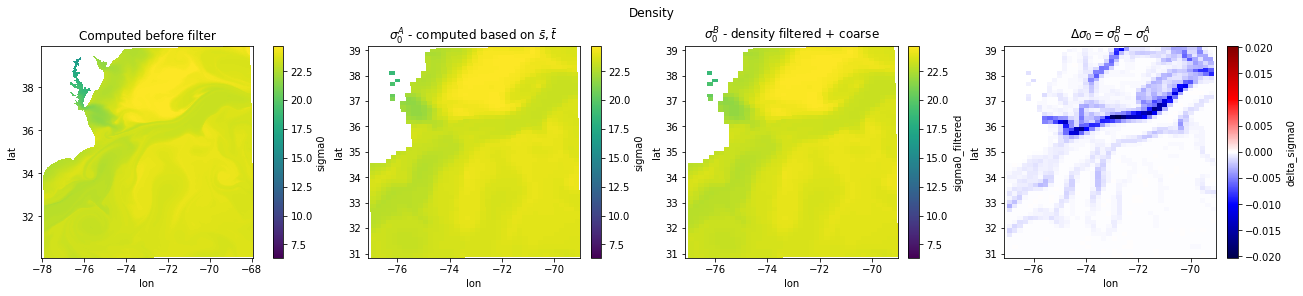

In [42]:
fig, ax = plt.subplots(ncols=4, constrained_layout=True, figsize=(18,4))
fig.suptitle('Density')
heatmap0 = (dataHR[slice_cut].isel(time_counter=time_counter_to_plot)).sigma0.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Computed before filter')

dataLR.isel(time_counter=time_counter_to_plot).sigma0[slice_cut].plot(ax=ax[1], x='lon', y='lat', norm=heatmap0.norm, cmap=heatmap0.cmap)
ax[1].set(title=r'$\sigma_0^A$ - computed based on $\bar{s}, \bar{t}$')

dataLR.isel(time_counter=time_counter_to_plot).sigma0_filtered[slice_cut].plot(ax=ax[2], x='lon', y='lat', norm=heatmap0.norm, cmap=heatmap0.cmap)
ax[2].set(title=r'$\sigma_0^B$ - density filtered + coarse')

dataLR.isel(time_counter=time_counter_to_plot).delta_sigma0[slice_cut].plot(ax=ax[3], x='lon', y='lat', cmap='seismic')
ax[3].set(title=r'$\Delta \sigma_0 = \sigma_0^B - \sigma_0^A$')
plt.show()

# Density derivatives

## Thermal and haline expansion coefficients

In [43]:
dataLR["alpha"], dataLR["beta"] = eos_module.alpha_beta(dataLR["sal"], dataLR["CT"])

In [44]:
# fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
# (dataLR.isel(time_counter=time_counter_to_plot)).alpha[slice_cut].plot(ax=ax[0],x='lon', y='lat')
# ax[0].set(title=r'$\alpha$')
# (dataLR.isel(time_counter=time_counter_to_plot)).beta[slice_cut].plot(ax=ax[1],x='lon', y='lat')
# ax[1].set(title=r'$\beta$')
# plt.show()

## Second derivatives of $\rho$

In [45]:
dataLR['spec_vol_sa_sa'], dataLR['spec_vol_sa_ct'], dataLR['spec_vol_ct_ct'] = eos_module.specvol_second_derivatives(dataLR['sal'], dataLR['CT'])

In [46]:
# fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))
# (dataLR.isel(time_counter=time_counter_to_plot)).spec_vol_sa_sa[slice_cut].plot(ax=ax[0],x='lon', y='lat')
# ax[0].set(title=r'$ \partial^2 v/ \partial S^2$')
# (dataLR.isel(time_counter=time_counter_to_plot)).spec_vol_sa_ct[slice_cut].plot(ax=ax[1],x='lon', y='lat')
# ax[1].set(title=r'$ \partial^2 v/ \partial S \partial \Theta$')
# (dataLR.isel(time_counter=time_counter_to_plot)).spec_vol_ct_ct[slice_cut].plot(ax=ax[2],x='lon', y='lat')
# ax[2].set(title=r'$ \partial^2 v/ \partial \Theta^2$')
# plt.show()

In [47]:
dataLR['rho_sa_sa'], dataLR['rho_sa_ct'], dataLR['rho_ct_ct'] = eos_module.rho_second_derivatives(dataLR['sal'], dataLR['CT'])

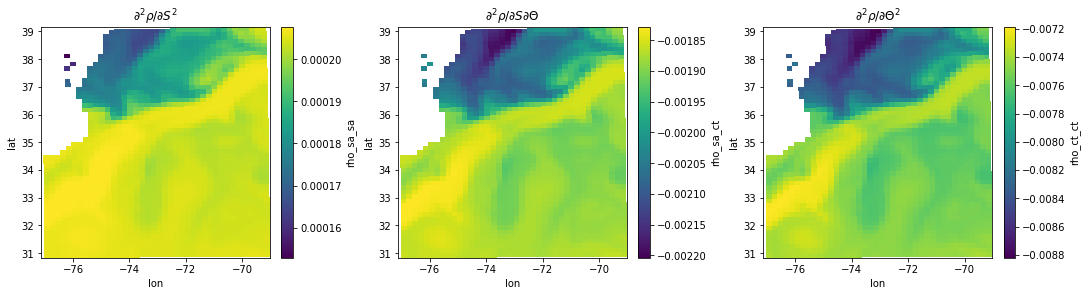

In [48]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))
(dataLR.isel(time_counter=time_counter_to_plot)).rho_sa_sa[slice_cut].plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'$ \partial^2 \rho/ \partial S^2$')
(dataLR.isel(time_counter=time_counter_to_plot)).rho_sa_ct[slice_cut].plot(ax=ax[1],x='lon', y='lat')
ax[1].set(title=r'$ \partial^2 \rho/ \partial S \partial \Theta$')
(dataLR.isel(time_counter=time_counter_to_plot)).rho_ct_ct[slice_cut].plot(ax=ax[2],x='lon', y='lat')
ax[2].set(title=r'$ \partial^2 \rho/ \partial \Theta^2$')
plt.show()

# Spatial derivatives (finite differences)

In [49]:
# def gradx(dataArray, delta_x) :
#     return (dataArray.shift(x=-1) - dataArray)/delta_x
# def grady(dataArray, delta_y) :
#     return (dataArray.shift(y=-1) - dataArray)/delta_y

In [50]:
# def diffs_x(dataArray) :
#     return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
# def diffs_y(dataArray) :
#     return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [51]:
def diffs_x(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffs_y(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [52]:
def diffs2_x(dataArray) :
    dataArray.coords["x_scaled"] = dataArray['x']*dataArray['e1t']
    return dataArray.differentiate("x_scaled")*data.array['e1t']
def diffs2_y(dataArray, delta_y) :
    dataArray.coords["y_scaled"] = dataArray['y']*dataArray['e2t']
    return dataArray.differentiate("y_scaled")*dataArray['e2t']

In [53]:
dataLR['temp_diffs_x'] = diffs_x(dataLR['CT'])
dataLR['temp_diffs_y'] = diffs_y(dataLR['CT'])
dataLR['sal_diffs_x'] = diffs_x(dataLR['sal'])
dataLR['sal_diffs_y'] = diffs_y(dataLR['sal'])

In [54]:
dataLR['temp_diffs_sqr'] = 0.5*dataLR['rho_ct_ct']*(dataLR['temp_diffs_x']**2 + dataLR['temp_diffs_y']**2)
dataLR['sal_diffs_sqr'] = 0.5*dataLR['rho_sa_sa']*(dataLR['sal_diffs_x']**2 + dataLR['sal_diffs_y']**2)
dataLR['temp_sal_diffs_sqr'] = dataLR['rho_sa_ct']*np.sqrt(dataLR['temp_diffs_x']**2 + dataLR['temp_diffs_y']**2)*np.sqrt(dataLR['sal_diffs_x']**2 + dataLR['sal_diffs_y']**2)

In [55]:
dataLR['sum_diffs_sqr'] = dataLR['temp_diffs_sqr'] + dataLR['sal_diffs_sqr'] + dataLR['temp_sal_diffs_sqr'] 

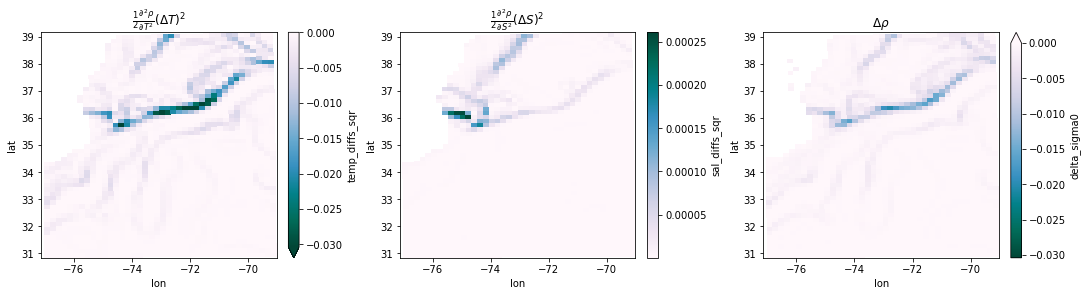

In [56]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))
norm = colors.Normalize(vmin=1.5*dataLR.isel(time_counter=time_counter_to_plot).delta_sigma0[slice_cut].min().values, vmax=0.)
color_map='PuBuGn_r'
(dataLR.isel(time_counter=time_counter_to_plot)).temp_diffs_sqr[slice_cut].plot(ax=ax[0],x='lon', y='lat', norm=norm, cmap=color_map)
ax[0].set(title=r'$\frac{1}{2}\frac{\partial^2 \rho}{\partial T^2} (\Delta T)^2$')
(dataLR.isel(time_counter=time_counter_to_plot)).sal_diffs_sqr[slice_cut].plot(ax=ax[1],x='lon', y='lat', cmap='PuBuGn')
ax[1].set(title=r'$\frac{1}{2}\frac{\partial^2 \rho}{\partial S^2} (\Delta S)^2$')

(dataLR.isel(time_counter=time_counter_to_plot)).delta_sigma0[slice_cut].plot(ax=ax[2],x='lon', y='lat', norm=norm, cmap=color_map)
ax[2].set(title=r'$\Delta \rho$')

plt.show()

# Spatial covariance

In [57]:
# %time corr_temp_diffs_sqr = xr.corr(dataLR['temp_diffs_sqr'], dataLR.delta_sigma0, dim=['x', 'y']).compute()

# corr_temp_diffs_sqr.to_netcdf("Data/region1_filter_30km_coarse_12/corr_temp_diffs_sqr_summer.nc")

In [58]:
# %time corr_sum_temp_sal_diffs_sqr = xr.corr(dataLR['sum_diffs_sqr'], dataLR.delta_sigma0, dim=['x', 'y']).compute()

# corr_sum_temp_sal_diffs_sqr.to_netcdf("Data/region1_filter_30km_coarse_12/corr_sum_temp_sal_diffs_sqr_summer.nc")

In [59]:
corr_temp_diffs_sqr = xr.open_dataarray("Data/region1_filter_30km_coarse_12/corr_temp_diffs_sqr_summer.nc")

In [60]:
corr_sum_temp_sal_diffs_sqr = xr.open_dataarray("Data/region1_filter_30km_coarse_12/corr_sum_temp_sal_diffs_sqr_summer.nc")

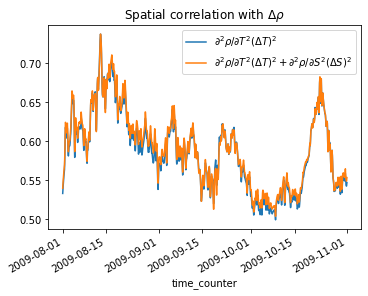

In [61]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
(corr_temp_diffs_sqr).plot(label=r'$\partial^2 \rho/\partial T^2 (\Delta T)^2$')
(corr_sum_temp_sal_diffs_sqr).plot(label=r'$\partial^2 \rho/\partial T^2 (\Delta T)^2 + \partial^2 \rho/\partial S^2 (\Delta S)^2$')
ax.set(title=r'Spatial correlation with $\Delta \rho$')
ax.legend()
#plt.savefig("corr_delta_rho_vs_nabla_s_nabla_b.png")
plt.show()

# Non-dimensionalization of data

In [62]:
delta_sigma_max = 0.1

In [63]:
delta_sigma_max

0.1

In [64]:
rho_coef = 1./delta_sigma_max

In [65]:
dataLR['nondim_delta_sigma0'] = np.abs(dataLR.delta_sigma0 * rho_coef)

In [66]:
dataLR['nondim_CT'] = dataLR['CT']*np.sqrt(0.5*np.abs(dataLR['rho_ct_ct']/delta_sigma_max))
dataLR['nondim_sal'] = dataLR['sal']*np.sqrt(0.5*np.abs(dataLR['rho_sa_sa']/delta_sigma_max))

In [67]:
dataLR['nondim_CT_diff_x'] = diffs_x(dataLR['nondim_CT'])
dataLR['nondim_CT_diff_y'] = diffs_y(dataLR['nondim_CT'])
dataLR['nondim_CT_diff_sqr'] = dataLR['nondim_CT_diff_x']**2 + dataLR['nondim_CT_diff_y']**2

In [68]:
dataLR['nondim_sal_diff_x'] = diffs_x(dataLR['nondim_sal'])
dataLR['nondim_sal_diff_y'] = diffs_y(dataLR['nondim_sal'])
dataLR['nondim_sal_diff_sqr'] = dataLR['nondim_sal_diff_x']**2 + dataLR['nondim_sal_diff_y']**2

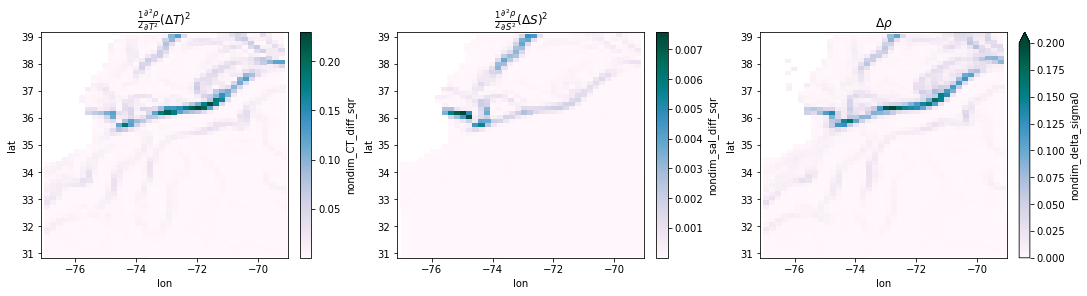

In [69]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))
norm = colors.Normalize(vmin=0., vmax=0.2)
color_map='PuBuGn'
(dataLR.isel(time_counter=time_counter_to_plot)).nondim_CT_diff_sqr[slice_cut].plot(ax=ax[0],x='lon', y='lat', cmap=color_map)
ax[0].set(title=r'$\frac{1}{2}\frac{\partial^2 \rho}{\partial T^2} (\Delta T)^2$')
(dataLR.isel(time_counter=time_counter_to_plot)).nondim_sal_diff_sqr[slice_cut].plot(ax=ax[1],x='lon', y='lat', cmap=color_map)
ax[1].set(title=r'$\frac{1}{2}\frac{\partial^2 \rho}{\partial S^2} (\Delta S)^2$')

(dataLR.isel(time_counter=time_counter_to_plot)).nondim_delta_sigma0[slice_cut].plot(ax=ax[2],x='lon', y='lat', cmap=color_map, norm=norm)
ax[2].set(title=r'$\Delta \rho$')

plt.show()

# Histograms

In [70]:
nb_of_bins = 200

In [71]:
bins_delta_sigma = np.linspace(-1., 0.)

In [72]:
x = dataLR['nondim_CT_diff_x']**2 + dataLR['nondim_CT_diff_y']**2

In [73]:
x.name = 'x'

In [74]:
# bins_x = np.linspace(x.isel(time_counter=time_counter_to_plot).min().values, \
#                              1.2*x.isel(time_counter=time_counter_to_plot).max().values, nb_of_bins)

In [75]:
# %time hist_diffs_temp_sqr = histogram(dataLR.nondim_delta_sigma0[slice_cut], x[slice_cut], \
#                                  bins=[bins_delta_sigma, bins_x]).compute()

In [76]:
# hist_diffs_temp_sqr.to_netcdf("Data/region1_filter_30km_coarse_12/hist_diffs_temp_sqr_summer.nc")

In [77]:
hist_diffs_temp_sqr = xr.open_dataarray("Data/region1_filter_30km_coarse_12/hist_diffs_temp_sqr_summer.nc")

In [78]:
# max_counter = hist_diffs_temp_sqr.max()

# fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
# hist_diffs_temp_sqr.plot(ax=ax, norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
# ax.plot(hist_diffs_temp_sqr.x_bin, -0.5*hist_diffs_temp_sqr.x_bin)
# ax.set(xlim=[0,1.0], ylim=[-1.,0], xlabel=r'Bins $(\Delta T^\prime)^2$')

In [79]:
# max_counter = hist_diffs_temp_sqr.max()

# fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
# hist_diffs_temp_sqr.plot(ax=ax[0], norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
# hist_diffs_temp_sqr_winter.plot(ax=ax[1], norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
# ax[0].set(title='Region 1, summer')
# ax[1].set(title='Region 1, winter')
# for axis in ax :
#     axis.plot(hist_diffs_temp_sqr_winter.x_bin, -1*hist_diffs_temp_sqr_winter.x_bin)
#     axis.set(xlim=[0,1.0], ylim=[-1.,0], xlabel=r'Bins $(\Delta T^\prime)^2$')
# ax[0].set(ylabel=r'Bins $\Delta \rho^\prime$')
# ax[1].set(ylabel='')
# plt.savefig('histograms_region1_winter_summer.png')

# Compare histograms for different regions and seasons

In [6]:
delta_sigma_max = -0.1
rho_coef = 1./delta_sigma_max
filter_scale = 30000
coarsen_window_size = 12

nb_of_bins = 200
bins_delta_sigma = np.linspace(0., 1., nb_of_bins)
slice_cut = dict(x=slice(4,-4),y=slice(4,-4))
time_counter_to_plot=1

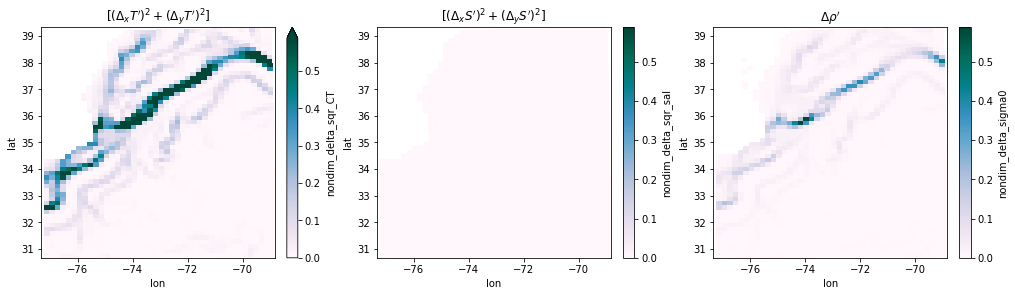

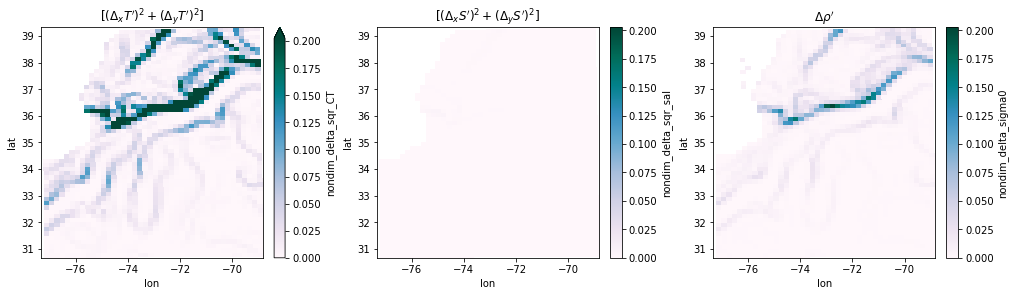

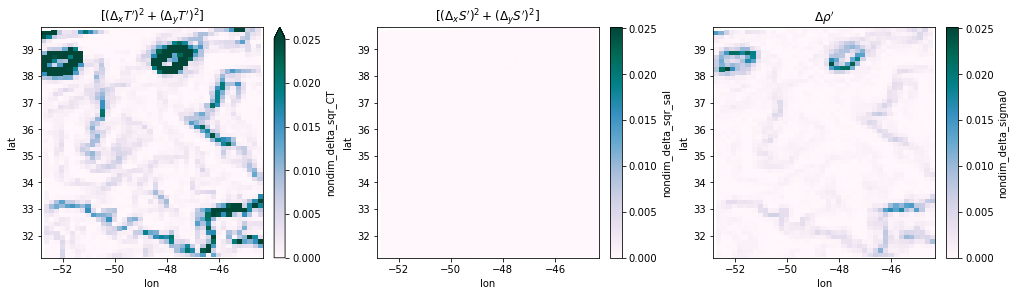

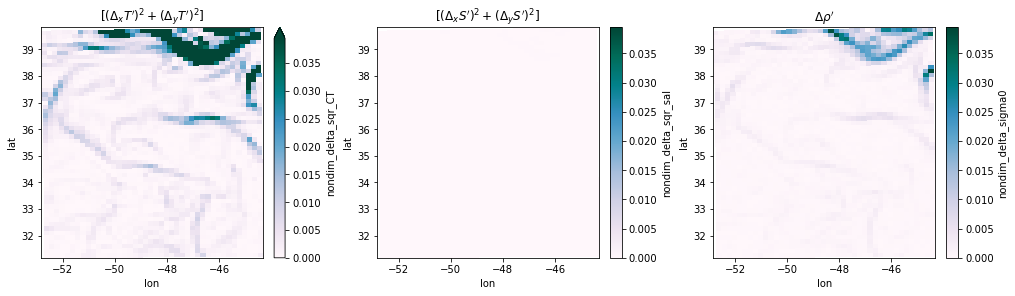

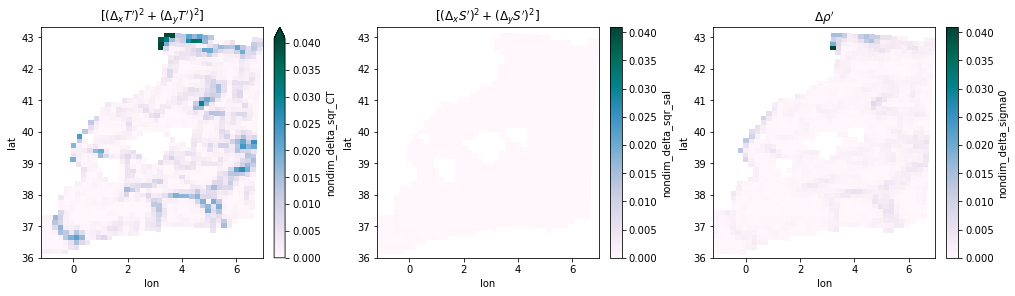

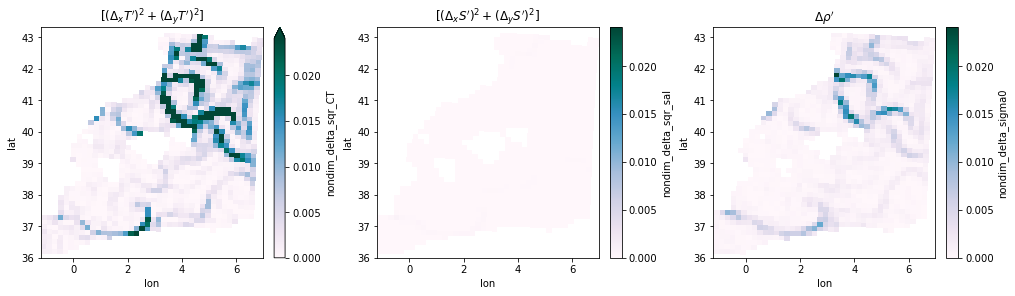

In [81]:
for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        dataHR = cat.eNATL60(region=region,datatype='surface_hourly', season=season).to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})
        # params for filter
        area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        wet_mask = xr.DataArray(dataHR.umask, dims=['y','x'])
        kappa_w = xr.ones_like(dxw)
        kappa_s = xr.ones_like(dxw)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            filter_scale=filter_scale,    
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered["sst"] = gaussian_filter.apply(dataHR.sosstsst, dims=['y', 'x'])
        data_filtered["sal"] = gaussian_filter.apply(dataHR.sosaline, dims=['y', 'x'])
        # spatial coarsening
        dataLR = downsample(data_filtered, coarsen_window_size, area, wet_mask)
        # computation of density correction
        dataHR['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataHR['sosaline'], dataHR['sosstsst'], dask='parallelized')
        dataHR['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, dataHR['sosaline'], dataHR['CT'], dask='parallelized')
        data_filtered["sigma0_filtered"] = gaussian_filter.apply(dataHR.sigma0, dims=['y', 'x'])
        dataLR["sigma0_filtered"] = downsample(data_filtered["sigma0_filtered"], coarsen_window_size, area, wet_mask)
        dataLR["CT"] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataLR['sal'], dataLR['sst'], dask='parallelized')
        dataLR["sigma0"] = xr.apply_ufunc(gsw.density.sigma0, dataLR["sal"], dataLR["CT"], dask='parallelized')
        dataLR["delta_sigma0"] = dataLR["sigma0_filtered"] - dataLR["sigma0"]
        # derivatives of density from teos-10
        dataLR['rho_sa_sa'], dataLR['rho_sa_ct'], dataLR['rho_ct_ct'] = eos_module.rho_second_derivatives(dataLR['sal'], dataLR['CT'])
        # spatial defferences of salinity and temperature
        dataLR['CT_diff_x'] = diffs_x(dataLR['CT']); dataLR['CT_diff_y'] = diffs_y(dataLR['CT'])
        dataLR['sal_diff_x'] = diffs_x(dataLR['sal']); dataLR['sal_diff_y'] = diffs_y(dataLR['sal'])
        dataLR['CT_diff_sqr'] = dataLR['CT_diff_x']**2 +dataLR['CT_diff_y']**2
        dataLR['sal_diff_sqr'] = dataLR['sal_diff_x']**2 +dataLR['sal_diff_y']**2
        # non-dimesionalization
        dataLR['nondim_delta_sigma0'] = np.abs(dataLR.delta_sigma0 * rho_coef)
        dataLR['nondim_delta_sqr_CT'] = dataLR['CT_diff_sqr']*(np.abs(dataLR['rho_ct_ct']*rho_coef))
        dataLR['nondim_delta_sqr_sal'] = dataLR['sal_diff_sqr']*(np.abs(dataLR['rho_sa_sa']*rho_coef))
        # plot
        fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
        norm = colors.Normalize(vmin=0., vmax=dataLR.isel(time_counter=time_counter_to_plot).nondim_delta_sigma0[slice_cut].max().values)
        color_map='PuBuGn'
        (dataLR.isel(time_counter=time_counter_to_plot)).nondim_delta_sqr_CT[slice_cut].plot(ax=ax[0],x='lon', y='lat', norm=norm, cmap=color_map)
        ax[0].set(title=r'$[(\Delta_x T^\prime)^2 + (\Delta_y T^\prime)^2]$')
        (dataLR.isel(time_counter=time_counter_to_plot)).nondim_delta_sqr_sal[slice_cut].plot(ax=ax[1],x='lon', y='lat', norm=norm, cmap=color_map)
        ax[1].set(title=r'$[(\Delta_x S^\prime)^2 + (\Delta_y S^\prime)^2]$')
        (dataLR.isel(time_counter=time_counter_to_plot)).nondim_delta_sigma0[slice_cut].plot(ax=ax[2],x='lon', y='lat', norm=norm, cmap=color_map)
        ax[2].set(title=r'$\Delta \rho^\prime$')
        plt.savefig("Data/Compare_histograms/plots_temp_sqr_region"+region+"_filter%2.0fkm_coarse%2.0f_"% (filter_scale*0.001, coarsen_window_size)+season+".png")

        pred_variable = dataLR['nondim_delta_sqr_CT']
        pred_variable.name='nondim_delta_sqr_CT'
        bins_x = np.linspace(pred_variable.isel(time_counter=time_counter_to_plot).min().values, 1.2*pred_variable.isel(time_counter=time_counter_to_plot).max().values, nb_of_bins)
        bins_delta_sigma = np.linspace(dataLR.nondim_delta_sigma0[slice_cut].isel(time_counter=time_counter_to_plot).min().values, 1.2*dataLR.nondim_delta_sigma0[slice_cut].isel(time_counter=time_counter_to_plot).max().values, nb_of_bins)
        hist_diffs_temp_sqr = histogram(dataLR.nondim_delta_sigma0[slice_cut], pred_variable[slice_cut], bins=[bins_delta_sigma, bins_x]).compute()
        hist_diffs_temp_sqr.to_netcdf("Data/Compare_histograms/hist_diffs_temp_sqr_region"+region+"_filter%2.0fkm_coarse%2.0f_"% (filter_scale*0.001, coarsen_window_size)+season+".nc")

# Non-dimensionalization

Density correction: $\Delta \rho^\prime = \frac{ \Delta \rho}{|\Delta \rho_{max}|} $

Conservative temperature: $T^\prime = T \sqrt{\frac{1}{|\Delta \rho_{max}|} \frac{\partial^2 \rho}{\partial T^2}}$ </br>
Salinity : $S^\prime = S \sqrt{\frac{1}{|\Delta \rho_{max}|} \frac{\partial^2 \rho}{\partial S^2}}$

# Plot histograms

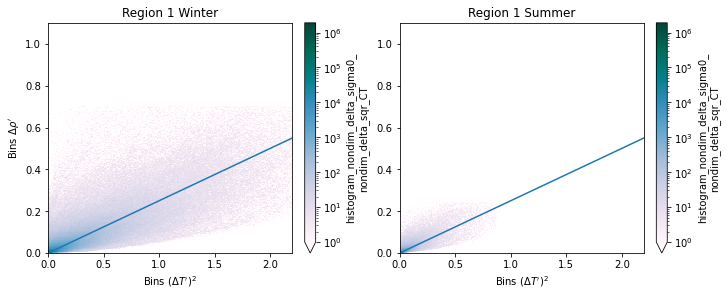

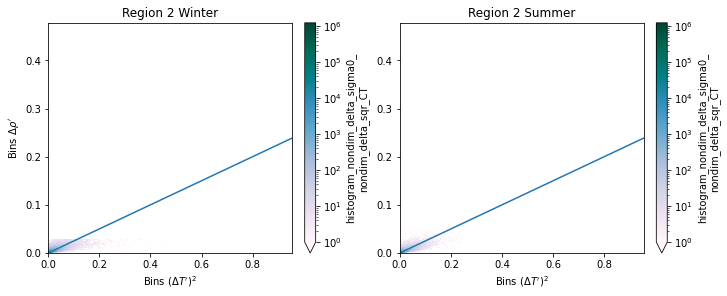

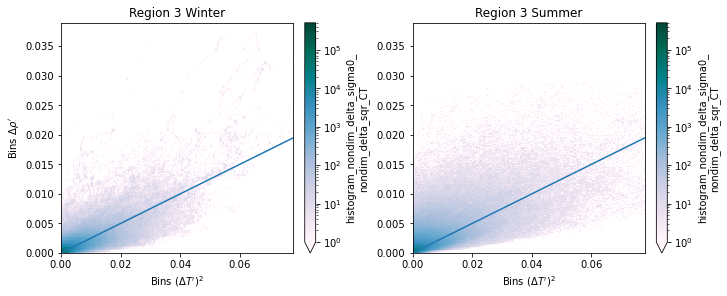

In [12]:
for region in ['1', '2', '3'] :
    hist_winter = xr.open_dataarray("Data/Compare_histograms/hist_diffs_temp_sqr_region"+region+"_filter%2.0fkm_coarse%2.0f_"% (filter_scale*0.001, coarsen_window_size)+"fma.nc")
    hist_summer = xr.open_dataarray("Data/Compare_histograms/hist_diffs_temp_sqr_region"+region+"_filter%2.0fkm_coarse%2.0f_"% (filter_scale*0.001, coarsen_window_size)+"aso.nc")
    max_counter = np.max([hist_summer.max().values, hist_winter.max().values])
    
    fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
    hist_winter.plot(ax=ax[0], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
    hist_summer.plot(ax=ax[1], norm=colors.LogNorm(vmin=1, vmax=max_counter), cmap='PuBuGn')
    ax[0].set(title='Region ' + region +' Winter')
    ax[1].set(title='Region ' + region +' Summer')
    for axis in ax :
        axis.plot(hist_winter.nondim_delta_sqr_CT_bin, 0.25*hist_winter.nondim_delta_sqr_CT_bin)
        axis.set(ylim=[0,0.5*hist_winter.nondim_delta_sqr_CT_bin.max()], xlim=[0,hist_winter.nondim_delta_sqr_CT_bin.max()], xlabel=r'Bins $(\Delta T^\prime)^2$')
    ax[0].set(ylabel=r'Bins $\Delta \rho^\prime$')
    ax[1].set(ylabel='')
    # plt.savefig('Data/Compare_histograms/histograms_region'+region+'_winter_summer.png')